In [1]:
import pickle
import joblib
import sklearn
import random
import os
import pandas as pd
import numpy as np

from src.pipelines.magic_loop import load_transformation, filter_drop, \
                                      transformation_pipeline, train_test_split, NUM_VARS, CAT_VARS

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
sklearn.__version__

'0.23.2'

In [3]:
os.chdir("..")

In [4]:
path = os.getcwd()
path

'/home/carotova/Documents/MCD/Intro_DS/accidentes-viales-CDMX'

In [5]:
joblib.__version__

'0.16.0'

In [6]:
ambulancias_disponibles_al_dia = 20.0
num_llamadas_al_dia = 550.0

In [7]:
df = load_transformation(path)

Opening feature engineering pickle from output path
Feature Engineering pickle successfully retrieved.


In [8]:
# Load all X_train, y_train, X_test, y test
X_train = pickle.load(open("output/X_train.pkl", 'rb'))
y_train = pickle.load(open("output/Y_train.pkl", 'rb'))
X_test = pickle.load(open("output/X_test.pkl", 'rb'))
y_test = pickle.load(open("output/Y_test.pkl", 'rb'))

In [9]:
general = pd.concat([X_train, X_test])

In [13]:
X_train.shape

(967884, 36)

In [15]:
y_train.shape

(967884,)

In [16]:
X_test.shape

(414808, 36)

In [17]:
y_test.shape

(414808,)

In [92]:
y_test.sum()

80933

# Random Forest

In [9]:
path = "output/random_forest.joblib"
model = joblib.load(path)

In [10]:
model

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=RandomForestClassifier(oob_score=1, random_state=1789),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [100, 200, 400]},
             scoring='precision')

In [11]:
model.best_params_

{'max_depth': 15, 'n_estimators': 100}

In [12]:
# predicciones con el mejor predictor 
predicted_labels = model.predict(X_test)

In [13]:
predicted_labels.shape

(414808,)

In [14]:
# predicciones en score con el mejor predictor
predicted_scores = model.predict_proba(X_test)

In [15]:
predicted_scores.shape

(414808, 2)

## ROC

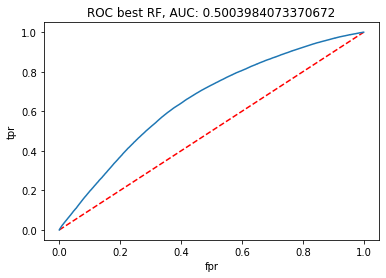

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

%matplotlib inline

fpr, tpr, thresholds = roc_curve(y_test, predicted_scores[:,1], pos_label=1)

plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

## Matriz de confusión

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, predicted_labels)

array([[333679,    196],
       [ 80821,    112]])

## Precision, recall, thresholds

In [18]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_2 = precision_recall_curve(y_test, predicted_scores[:,1], pos_label=1)

In [19]:
thresholds_2 = np.append(thresholds_2, 1)

In [20]:
(precision.shape, recall.shape, thresholds_2.shape)

((192424,), (192424,), (192424,))

In [21]:
from sklearn.metrics import precision_score

def precision_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return precision_score(y_true, y_pred)

In [22]:
from sklearn.metrics import precision_score

def precision_at_k_(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*(len(y_scores)-1))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return precision_score(y_true, y_pred)

In [23]:
from sklearn.metrics import recall_score
def recall_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return recall_score(y_true, y_pred)

In [24]:
from sklearn.metrics import recall_score
def recall_at_k_(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*(len(y_scores)-1))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return recall_score(y_true, y_pred)

In [35]:
def get_top_k(y_scores, k):
    pass

In [29]:
def pr_k_curve(y_true, y_scores, save_target=None):
    k_values = list(np.arange(0.1, 1.1, 0.1))
    pr_k = pd.DataFrame()

    for k in k_values:
        d = dict()
        d['k'] = k
        ## get_top_k es una función que ordena los scores de
        ## mayor a menor y toma los k% primeros
        #top_k = get_top_k(y_scores, k)
        #top_k = y_scores
        # print(precision_at_k(y_true, y_scores, k))
        d['precision'] = precision_at_k_(y_true, y_scores, k)#(top_k)
        d['recall'] = recall_at_k_(y_true, y_scores, k)#(top_k, predictions)

        pr_k = pr_k.append(d, ignore_index=True)

    # para la gráfica
    fig, ax1 = plt.subplots()
    ax1.plot(pr_k['k'], pr_k['precision'], label='precision')
    ax1.plot(pr_k['k'], pr_k['recall'], label='recall')
    plt.legend()

    if save_target is not None:
        plt.savefig(save_target, dpi=300)
    else:
        plt.show

    return pr_k

In [30]:
k = ambulancias_disponibles_al_dia/num_llamadas_al_dia
precision_at_k(predicted_labels, y_test, k)

0.0013838607243028185

In [89]:
precision_at_k(y_test, predicted_labels, k)

0.19510954465680508

In [31]:
recall_at_k(predicted_labels, y_test, k)

0.36363636363636365

In [88]:
recall_at_k(y_test, predicted_labels, k)

1.0

,k,precision,recall
0,0.1,0.003447,0.330961
1,0.2,0.002032,1.000000
2,0.3,0.002032,1.000000
3,0.4,0.002032,1.000000
4,0.5,0.002032,1.000000
5,0.6,0.002032,1.000000
6,0.7,0.002032,1.000000
7,0.8,0.002032,1.000000
8,0.9,0.002032,1.000000
9,1.0,0.002032,1.000000


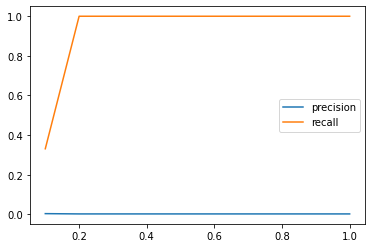

In [91]:
pr_k_curve(predicted_labels, y_test)

## Reporte de métricas

In [33]:
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({'threshold': thresholds_2,'precision': precision,
                    'recall': recall})
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)
    
    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']
    
    df = df_1.merge(df_2, on="threshold")
    
    return df

In [34]:
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
metrics_report

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
0,0.018169,0.195115,1.000000,0.326520,1.000000,0.999967,0.000033,0.000000
1,0.018329,0.195114,0.999988,0.326519,0.999988,0.999958,0.000042,0.000012
2,0.018973,0.195117,0.999988,0.326523,0.999988,0.999940,0.000060,0.000012
3,0.019026,0.195118,0.999988,0.326525,0.999988,0.999931,0.000069,0.000012
4,0.019198,0.195120,0.999988,0.326527,0.999988,0.999922,0.000078,0.000012
...,...,...,...,...,...,...,...,...
136920,0.641095,0.428571,0.000037,0.000074,0.000037,0.000012,0.999988,0.999963
136921,0.643071,0.500000,0.000037,0.000074,0.000037,0.000009,0.999991,0.999963
136922,0.657500,0.250000,0.000012,0.000025,0.000012,0.000009,0.999991,0.999988
136923,0.665833,0.333333,0.000012,0.000025,0.000012,0.000006,0.999994,0.999988


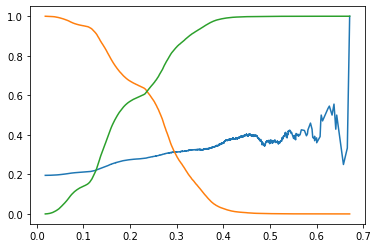

In [40]:
plt.plot(metrics_report.threshold, metrics_report.precision)
plt.plot(metrics_report.threshold, metrics_report.recall)
plt.plot(metrics_report.threshold, metrics_report.tnr)

plt.show()

¿Qué métrica escogemos?

TP = El modelo dice que es llamada falsa,    y sí es llamada falsa

TN = El modelo dice que es llamada no falsa, y no es llamada falsa**

FP = El modelo dice que es llamada falsa,    y no es llamada falsa

FN = El modelo dice que es llamada no falsa,   y sí es llamada falsa

Decidimos TNR dado que nos interesa ayudar verificar que una llamada que el modelo dice que no es falsa, realmente no es falsa, ya que probablemente se necesite enviar una ambulancia.

De acuerdo a las métricas del negocio, les interesa tener un TNR mayor al 80%. Es decir, de 10 llamadas que el modelo dice que son llamadas legítimas, por lo menos 8 deben ser realmente legítimas.

In [45]:
negocio = metrics_report[metrics_report.tnr >= 0.8]

In [46]:
negocio

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
105343,0.285209,0.309318,0.369429,0.336712,0.369429,0.199961,0.800039,0.630571
105344,0.285211,0.309330,0.369417,0.336714,0.369417,0.199943,0.800057,0.630583
105345,0.285211,0.309340,0.369417,0.336720,0.369417,0.199934,0.800066,0.630583
105346,0.285212,0.309343,0.369417,0.336721,0.369417,0.199931,0.800069,0.630583
105347,0.285212,0.309342,0.369404,0.336716,0.369404,0.199925,0.800075,0.630596
...,...,...,...,...,...,...,...,...
136920,0.641095,0.428571,0.000037,0.000074,0.000037,0.000012,0.999988,0.999963
136921,0.643071,0.500000,0.000037,0.000074,0.000037,0.000009,0.999991,0.999963
136922,0.657500,0.250000,0.000012,0.000025,0.000012,0.000009,0.999991,0.999988
136923,0.665833,0.333333,0.000012,0.000025,0.000012,0.000006,0.999994,0.999988


Matriz asociada a este punto de corte

In [58]:
punto_corte = negocio.head(1).threshold.values[0]
punto_corte 

0.2852090089237006

In [59]:
new_labels = [0 if score < punto_corte else 1 for score in predicted_scores[:,1]]

In [60]:
pd.Series(new_labels).sum()

96661

En la siguiente matriz de confusión podemos ver que con el nuevo punto de corte generamos más Falsos Positivo.

Columnas = Predicción

Renglones = Groundtruth

In [61]:
pd.DataFrame(confusion_matrix(y_test, new_labels))

,0,1
0,267113,66762
1,51034,29899


Matriz de confusión original:

In [53]:
pd.DataFrame(confusion_matrix(y_test, predicted_labels))

,0,1
0,333679,196
1,80821,112


# Decision Tree

In [62]:
path = "output/decision_tree.joblib"
model = joblib.load(path)

In [63]:
model

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=DecisionTreeClassifier(random_state=1789), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10],
                         'min_samples_leaf': [1, 3, 5]},
             scoring='precision')

In [64]:
model.best_params_

{'max_depth': 10, 'min_samples_leaf': 5}

In [65]:
# predicciones con el mejor predictor 
predicted_labels = model.predict(X_test)

In [66]:
predicted_labels.shape

(414808,)

In [67]:
# predicciones en score con el mejor predictor
predicted_scores = model.predict_proba(X_test)

In [68]:
predicted_scores.shape

(414808, 2)

## ROC

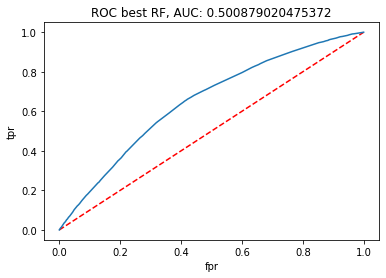

In [69]:
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

%matplotlib inline

fpr, tpr, thresholds = roc_curve(y_test, predicted_scores[:,1], pos_label=1)

plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

## Matriz de confusión

In [70]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, predicted_labels)

array([[333311,    564],
       [ 80654,    279]])

## Precision, recall, thresholds

In [71]:

from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_2 = precision_recall_curve(y_test, predicted_scores[:,1], pos_label=1)

In [72]:
thresholds_2 = np.append(thresholds_2, 1)

In [73]:
(precision.shape, recall.shape, thresholds_2.shape)

((440,), (440,), (440,))

In [74]:
precision_at_k(predicted_labels, y_test, k)

0.0034472959114329135

In [75]:
recall_at_k(predicted_labels, y_test, k)

0.3309608540925267

,k,precision,recall
0,0.1,0.003447,0.330961
1,0.2,0.002032,1.000000
2,0.3,0.002032,1.000000
3,0.4,0.002032,1.000000
4,0.5,0.002032,1.000000
5,0.6,0.002032,1.000000
6,0.7,0.002032,1.000000
7,0.8,0.002032,1.000000
8,0.9,0.002032,1.000000
9,1.0,0.002032,1.000000


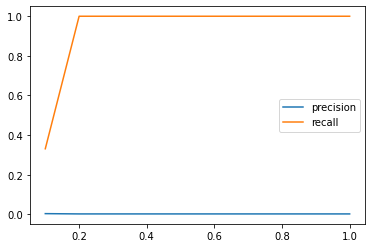

In [76]:
pr_k_curve(predicted_labels, y_test)

## Reporte de métricas

In [77]:
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({'threshold': thresholds_2,'precision': precision,
                    'recall': recall})
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)
    
    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']
    
    df = df_1.merge(df_2, on="threshold")
    
    return df

In [78]:
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
metrics_report

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
0,0.000000,0.195110,1.000000,0.326513,1.000000,1.000000,0.000000,0.000000
1,0.007812,0.195272,0.999333,0.326705,0.999333,0.998302,0.001698,0.000667
2,0.009174,0.195281,0.999283,0.326716,0.999283,0.998191,0.001809,0.000717
3,0.011209,0.195292,0.999271,0.326729,0.999271,0.998113,0.001887,0.000729
4,0.011396,0.195482,0.999073,0.326986,0.999073,0.996705,0.003295,0.000927
...,...,...,...,...,...,...,...,...
435,0.833333,0.269841,0.000210,0.000420,0.000210,0.000138,0.999862,0.999790
436,0.857143,0.200000,0.000111,0.000222,0.000111,0.000108,0.999892,0.999889
437,0.875000,0.179487,0.000086,0.000173,0.000086,0.000096,0.999904,0.999914
438,1.000000,0.172414,0.000062,0.000124,0.000062,0.000072,0.999928,0.999938


¿Qué métrica escogemos?

In [79]:
negocio = metrics_report[metrics_report.tnr >= 0.8]

In [80]:
negocio

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
274,0.280702,0.304736,0.351550,0.326473,0.351550,0.194426,0.805574,0.648450
275,0.282828,0.304800,0.351216,0.326366,0.351216,0.194183,0.805817,0.648784
276,0.283660,0.304842,0.351043,0.326316,0.351043,0.194049,0.805951,0.648957
277,0.283951,0.305369,0.350228,0.326264,0.350228,0.193117,0.806883,0.649772
278,0.284519,0.305418,0.350166,0.326265,0.350166,0.193039,0.806961,0.649834
...,...,...,...,...,...,...,...,...
435,0.833333,0.269841,0.000210,0.000420,0.000210,0.000138,0.999862,0.999790
436,0.857143,0.200000,0.000111,0.000222,0.000111,0.000108,0.999892,0.999889
437,0.875000,0.179487,0.000086,0.000173,0.000086,0.000096,0.999904,0.999914
438,1.000000,0.172414,0.000062,0.000124,0.000062,0.000072,0.999928,0.999938


Matriz asociada a este punto de corte

In [81]:
punto_corte = negocio.head(1).threshold.values[0]
punto_corte

0.2807017543859649

In [82]:
new_labels = [0 if score < punto_corte else 1 for score in predicted_scores[:,1]]

In [83]:
pd.Series(new_labels).sum()

93366

In [84]:
confusion_matrix(y_test, new_labels)

array([[268961,  64914],
       [ 52481,  28452]])

In [85]:
confusion_matrix(y_test, predicted_labels)

array([[333311,    564],
       [ 80654,    279]])